In [1]:
from typing import List

import einops
import torch
import torch.nn.functional as F
import torchvision
from IPython.display import display
from PIL import Image
from torch import nn
from torchvision import transforms

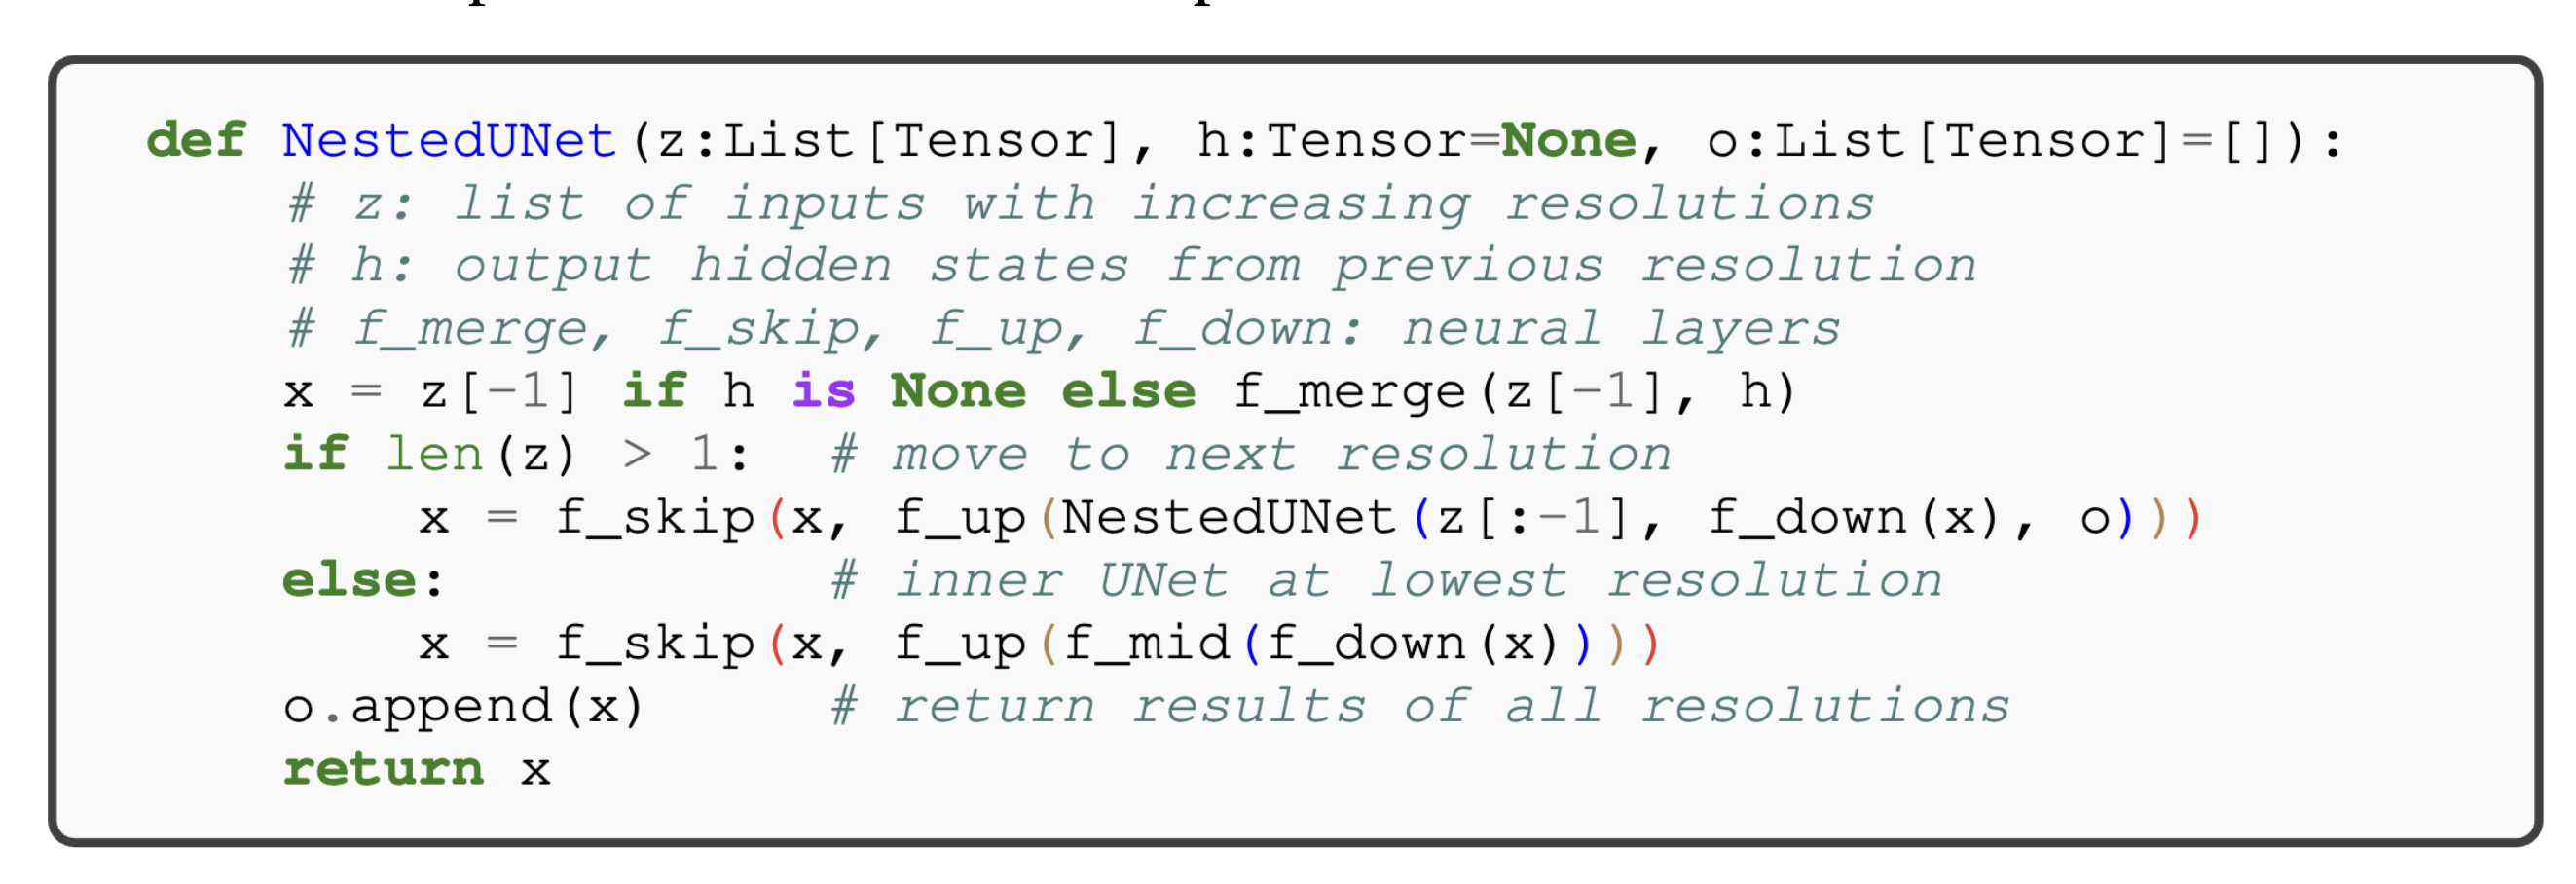

In [6]:
image = Image.open('imgs/nested_unet_img.png')
display(image)

In [7]:
from datasets.tiny_img.tiny_img import download_tinyImg200
from pathlib import Path

data_path = Path('./datasets/tiny_img')
download_tinyImg200(str(data_path))

Dataset was already downloaded to 'datasets/tiny_img/tiny-imagenet-200.zip'. Skip downloading


In [8]:
from datasets.tiny_img import tiny_img_dataset

val_dataser = tiny_img_dataset.TinyImagenetValRAM(str(data_path/'tiny-imagenet-200/val'), transform=transforms.ToTensor())

datasets/tiny_img/tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:10<00:00, 935.81it/s]


In [9]:
from datasets.tiny_img import tiny_img_dataset
from torchvision import transforms

train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
    ]
)


train_dataset = tiny_img_dataset.TinyImagenetTrainRAM(str(data_path/'tiny-imagenet-200/train'), transform=train_trainsforms)

datasets/tiny_img/tiny-imagenet-200/train: 100%|██████████| 200/200 [01:23<00:00,  2.39it/s]


In [ ]:
batch_size = 64
train_dataset = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=-1)

val_dataset = torch.utils.data.DataLoader(val_dataser,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=-1)

/home/timka/projects/ysda/genmod/ysda-mdm/.venv/lib64/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
# draw a batch of images
import matplotlib.pyplot as plt

import numpy as np
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

/home/timka/projects/ysda/genmod/ysda-mdm/.venv/lib64/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([64, 3, 64, 64])


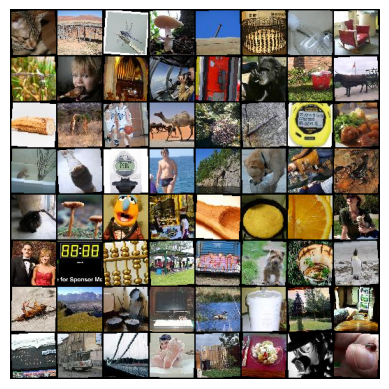

In [16]:
images, labels = next(iter(train_dataset))
print(images.shape)
imshow(torchvision.utils.make_grid(images))


/home/timka/projects/ysda/genmod/ysda-mdm/.venv/lib64/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([64, 3, 64, 64])


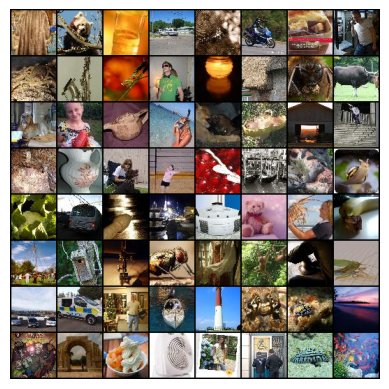

In [17]:
images, labels = next(iter(val_dataset))
print(images.shape)
imshow(torchvision.utils.make_grid(images))

In [18]:
class NestedUNet(nn.Module):
    pass

In [20]:
def f_merge(z: torch.Tensor, h: torch.Tensor):
    pass

In [21]:
def f_mid(x: torch.Tensor):
    pass

In [22]:
def f_down(x: torch.Tensor):
    pass

In [23]:
def f_up(x: torch.Tensor):
    pass

In [24]:
def f_skip(x: torch.Tensor):
    pass

In [25]:
def forward(z: List[torch.Tensor], h: torch.Tensor, o:List[torch.Tensor]):
    x = z[-1] if h is None else f_merge(z[-1], h)
    if len(z) > 1:
        x = f_skip(x, f_up(forward(z[:-1], f_down(x), o)))
    else:
        x = f_skip(x, f_up(f_mid(f_down(x))))

Base architecture (MDM-S64)

config: resolutions=[64,32,16] resolution_channels =[256 ,512 ,768] num_res_blocks =[2 ,2 ,2] num_attn_layers_per_block =[0 ,1 ,5] num_heads=8, schedule=’cosine’ emb_channels=1024, num_lm_attn_layers =2 , lm_feature_projected_channels =1024


In [26]:
import math

In [27]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [28]:
def zero_module(module):    # ста
    """
    Обнуляет параметры модуля и возвращает его.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module

In [ ]:
class SelfAttentionForLM(nn.Module):
    def __init__(
        self,
        channels,
        num_heads=8,
        num_head_channels=-1,
        use_attention_ffn=False,
        pos_emb=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert (
                channels % num_head_channels == 0
            ), f"q,k,v channels {channels} is not divisible by num_head_channels {num_head_channels}"
            self.num_heads = channels // num_head_channels

        self.norm = nn.LayerNorm(channels)
        self.qkv = nn.Linear(channels, channels * 3)
        self.proj_out = zero_module(nn.Linear(channels, channels))
        if use_attention_ffn:
            self.ffn = nn.Sequential(
                nn.LayerNorm(channels),
                nn.Linear(channels, 4 * channels),
                nn.GELU(),
                zero_module(nn.Linear(4 * channels, channels)),
            )
        else:
            self.ffn = None
        if pos_emb:
            from rotary_embedding_torch import RotaryEmbedding

            self.pos_emb = RotaryEmbedding(dim=channels // self.num_heads)
        else:
            self.pos_emb = None

    def attention(self, q, k, v, mask=None):
        bs, length, width = q.shape
        ch = width // self.num_heads
        scale = 1 / math.sqrt(math.sqrt(ch))
        q = q.reshape(bs, length, self.num_heads, ch)
        k = k.reshape(bs, length, self.num_heads, ch)
        if self.pos_emb is not None:
            q = self.pos_emb.rotate_queries_or_keys(q.permute(0, 2, 1, 3)).permute(
                0, 2, 1, 3
            )
            k = self.pos_emb.rotate_queries_or_keys(k.permute(0, 2, 1, 3)).permute(
                0, 2, 1, 3
            )
        weight = torch.einsum(
            "bthc,bshc->bhts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        if mask is not None:
            mask = mask.view(mask.size(0), 1, 1, mask.size(1))
            weight = weight.masked_fill(mask == 0, float("-inf"))
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum(
            "bhts,bshc->bthc", weight, v.reshape(bs, -1, self.num_heads, ch)
        )
        return a.reshape(bs, length, -1)

    def forward(self, x, mask):
        # assert (self.cond_dim is not None) == (cond is not None)
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.chunk(3, dim=-1)
        h = self.attention(q, k, v, mask)
        h = self.proj_out(h)
        x = x + h
        if self.ffn is not None:
            x = x + self.ffn(x)
        return x
    

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import List

@dataclass
class ResNetConfig:
    num_channels: int
    output_channels: int
    num_groups_norm: int = 32
    dropout: float = 0.0

@dataclass
class UNetConfig:
    resolution_channels: List[int] = field(default_factory=lambda: [128, 256, 512, 1024])
    num_residual_blocks: int = 2
    num_attention_layers: List[int] = field(default_factory=lambda: [0, 1, 1, 1])
    temporal_dim: int = 128
    dropout: float = 0.1
    num_groups_norm: int = 32
    conditioning_feature_proj_dim: int = -1
    conditioning_feature_dim: int = 768
    skip_mid_blocks: bool = False
    skip_normalization: bool = False
    nesting: bool = False  # Flag indicating if this UNet is nested inside another

@dataclass
class NestedSimpleUNetConfig(UNetConfig):
    """Configuration for Nested UNet architecture"""
    nesting: bool = True  # Always True for nested architecture
    inner_config: UNetConfig = field(
        default_factory=lambda: UNetConfig(nesting=True)
    )
    skip_inner_unet_input: bool = False  # Whether to skip adapter from outer to inner UNet

@dataclass
class Nested2SimpleUNetConfig(NestedSimpleUNetConfig):
    """Configuration for two levels of nesting"""
    inner_config: NestedSimpleUNetConfig = field(
        default_factory=lambda: NestedSimpleUNetConfig()
    )

@dataclass
class Nested3SimpleUNetConfig(Nested2SimpleUNetConfig):
    """Configuration for three levels of nesting"""
    inner_config: Nested2SimpleUNetConfig = field(
        default_factory=lambda: Nested2SimpleUNetConfig()
    )

In [ ]:
class PixelsAttention(nn.Module):
    def __init__(self, channels, num_heads=8, cond_dim=None):
        super().__init__()
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(32, channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.proj = zero_module(nn.Conv1d(channels, channels, 1))
        
        if cond_dim is not None:
            self.cond_proj = nn.Linear(cond_dim, channels)
        else:
            self.cond_proj = None

    def forward(self, x, conditioning=None, cond_mask=None):
        b, c, h, w = x.shape
        
        # Reshape and normalize
        x_flat = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x).reshape(b, c, -1))
        q, k, v = torch.split(qkv, c, dim=1)
        
        # Add conditioning if provided
        if conditioning is not None and self.cond_proj is not None:
            # Average conditioning across sequence length if mask not provided
            if cond_mask is None:
                cond_feat = conditioning.mean(dim=1)
            else:
                cond_feat = (conditioning * cond_mask.unsqueeze(-1)).sum(dim=1) / cond_mask.sum(dim=1, keepdim=True).clamp(min=1)
                
            cond_proj = self.cond_proj(cond_feat).unsqueeze(-1)
            k = k + cond_proj
            v = v + cond_proj

        # Attention
        scale = 1 / math.sqrt(c // self.num_heads)
        q = q.reshape(b, self.num_heads, c // self.num_heads, -1)
        k = k.reshape(b, self.num_heads, c // self.num_heads, -1)
        v = v.reshape(b, self.num_heads, c // self.num_heads, -1)
        
        attention = torch.einsum("bhci,bhcj->bhij", q, k) * scale
        attention = F.softmax(attention, dim=-1)
        
        out = torch.einsum("bhij,bhcj->bhci", attention, v)
        out = out.reshape(b, c, -1)
        
        # Projection
        out = self.proj(out)
        return (x_flat + out).reshape(b, c, h, w)


In [ ]:
class ResNet(nn.Module):
    def __init__(self, time_emb_channels, config: ResNetConfig):
        super().__init__()
        self.config = config
        self.norm1 = nn.GroupNorm(config.num_groups_norm, config.num_channels)
        self.conv1 = nn.Conv2d(
            config.num_channels,
            config.output_channels,
            kernel_size=3,
            padding=1,
            bias=True,
        )
        self.time_layer = nn.Linear(time_emb_channels, config.output_channels * 2)
        self.norm2 = nn.GroupNorm(config.num_groups_norm, config.output_channels)
        self.dropout = nn.Dropout(config.dropout)
        self.conv2 = zero_module(
            nn.Conv2d(
                config.output_channels,
                config.output_channels,
                kernel_size=3,
                padding=1,
                bias=True,
            )
        )
        if self.config.output_channels != self.config.num_channels:
            self.conv3 = nn.Conv2d(
                config.num_channels, config.output_channels, kernel_size=1, bias=True
            )

    def forward(self, x, temb):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        ta, tb = (
            self.time_layer(F.silu(temb)).unsqueeze(-1).unsqueeze(-1).chunk(2, dim=1)
        )
        assert h.size(0) == ta.size(0), "Batch size mismatch between activations and time embeddings"
        h = F.silu(self.norm2(h) * (1 + ta) + tb)
        h = self.dropout(h)
        h = self.conv2(h)
        if self.config.output_channels != self.config.num_channels:
            x = self.conv3(x)
        return h + x
        


In [ ]:
class ResNetBlock(nn.Module):
    def __init__(
        self,
        temporal_dim: int,
        num_residual_blocks: int,
        num_attention_layers: int,
        downsample_output: bool,
        upsample_output: bool,
        resnet_configs: list,
        conditioning_feature_dim: int = -1,
    ):
        super().__init__()
        assert (downsample_output and upsample_output) == False
        
        self.num_residual_blocks = num_residual_blocks
        self.num_attention_layers = num_attention_layers
        self.downsample_output = downsample_output
        self.upsample_output = upsample_output
        
        # Create ResNet modules
        self.resnets = nn.ModuleList()
        for i in range(num_residual_blocks):
            self.resnets.append(ResNet(temporal_dim, resnet_configs[i]))
        
        # Create attention modules
        self.attn = nn.ModuleList()
        for i in range(num_residual_blocks):
            for j in range(num_attention_layers):
                self.attn.append(
                    PixelsAttention(
                        resnet_configs[i].output_channels,
                        cond_dim=conditioning_feature_dim if conditioning_feature_dim > 0 else None,
                    )
                )
        
        # Create up/downsampling module
        if self.downsample_output:
            self.resample = nn.Conv2d(
                resnet_configs[-1].output_channels,
                resnet_configs[-1].output_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=True,
            )

        elif self.upsample_output:
            self.resample = nn.Conv2d(
                resnet_configs[-1].output_channels,
                resnet_configs[-1].output_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=True,
            )

    def forward(
        self,
        x,
        temb,
        skip_activations=None,
        return_activations=False,
        conditioning=None,
        cond_mask=None,
    ):
        activations = []
        for i in range(self.num_residual_blocks):
            if skip_activations is not None:
                skip_input = skip_activations.pop(0)
                x = torch.cat((x, skip_input), dim=1)

            x = self.resnets[i](x, temb)
            if self.num_attention_layers > 0:
                L = self.num_attention_layers
                for j in range(L):
                    x = self.attn[i * L + j](x, conditioning, cond_mask)
            
            activations.append(x)
        
        if self.downsample_output or self.upsample_output:
            if self.upsample_output:
                x = F.interpolate(x.type(torch.float32), scale_factor=2).type(x.dtype)
            x = self.resample(x)
            activations.append(x)
        
        if return_activations:
            return activations[-1]
        
        return x, activations if return_activations else x


In [ ]:
class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, config: UNetConfig):
        super().__init__()
        self.config = config
        self._config = config
        self.input_channels = input_channels
        self.output_channels = output_channels
        
        # Time embedding
        self.temporal_dim = config.temporal_dim
        time_embed_dim = config.temporal_dim
        self.time_embed = nn.Sequential(
            nn.Linear(time_embed_dim, time_embed_dim * 4),
            nn.SiLU(),
            nn.Linear(time_embed_dim * 4, time_embed_dim),
        )
        
        # Configure conditioning
        conditioning_feature_dim = -1
        if config.conditioning_feature_proj_dim > 0:
            self.lm_proj = nn.Linear(
                config.conditioning_feature_dim, config.conditioning_feature_proj_dim
            )
            conditioning_feature_dim = config.conditioning_feature_proj_dim
        elif config.conditioning_feature_dim > 0:
            conditioning_feature_dim = config.conditioning_feature_dim
            
        # Condition embedding
        if conditioning_feature_dim > 0:
            self.cond_emb = nn.Sequential(
                nn.Linear(conditioning_feature_dim, time_embed_dim),
                nn.SiLU(),
                nn.Linear(time_embed_dim, time_embed_dim),
            )
        
        # Input layer
        self.input_layer = nn.Conv2d(
            input_channels, config.resolution_channels[0], kernel_size=3, padding=1
        )
        
        # Build ResNet blocks configurations
        block_configs = []
        for i in range(len(config.resolution_channels) - 1):
            channels = []
            num_blocks = config.num_residual_blocks
            for j in range(num_blocks):
                in_ch = config.resolution_channels[i] if j == 0 else config.resolution_channels[i + 1]
                out_ch = config.resolution_channels[i + 1]
                channels.append(
                    ResNetConfig(
                        num_channels=in_ch,
                        output_channels=out_ch,
                        num_groups_norm=config.num_groups_norm,
                        dropout=config.dropout,
                    )
                )
            block_configs.append(channels)
        
        # Downsample blocks
        self.downsample_blocks = nn.ModuleList(
            [
                ResNetBlock(
                    temporal_dim=config.temporal_dim,
                    num_residual_blocks=config.num_residual_blocks,
                    num_attention_layers=config.num_attention_layers[i],
                    downsample_output=True,
                    upsample_output=False,
                    resnet_configs=block_configs[i],
                    conditioning_feature_dim=conditioning_feature_dim,
                )
                for i in range(len(block_configs) - 1)
            ]
        )
        
        # Middle blocks (between down and up)
        mid_config = block_configs[-1]
        self.mid_blocks = nn.ModuleList([
            ResNetBlock(
                temporal_dim=config.temporal_dim,
                num_residual_blocks=1,
                num_attention_layers=config.num_attention_layers[-1],
                downsample_output=False,
                upsample_output=False,
                resnet_configs=[mid_config[-1]],
                conditioning_feature_dim=conditioning_feature_dim,
            ),
            ResNetBlock(
                temporal_dim=config.temporal_dim,
                num_residual_blocks=1,
                num_attention_layers=config.num_attention_layers[-1],
                downsample_output=False,
                upsample_output=False,
                resnet_configs=[mid_config[-1]],
                conditioning_feature_dim=conditioning_feature_dim,
            )
        ])
        
        # Upsample blocks
        self.upsample_blocks = nn.ModuleList()
        for i in reversed(range(len(block_configs) - 1)):
            out_ch = config.resolution_channels[i]
            in_ch = config.resolution_channels[i + 1]
            
            # Modify configurations for upsample path
            up_configs = []
            for j in range(config.num_residual_blocks + 1):
                if j == config.num_residual_blocks:  # Last block
                    in_channels = in_ch
                    out_channels = out_ch
                else:
                    in_channels = in_ch if j == 0 else in_ch
                    out_channels = in_ch
                
                up_configs.append(
                    ResNetConfig(
                        num_channels=in_channels,
                        output_channels=out_channels,
                        num_groups_norm=config.num_groups_norm,
                        dropout=config.dropout,
                    )
                )
            
            self.upsample_blocks.append(
                ResNetBlock(
                    temporal_dim=config.temporal_dim,
                    num_residual_blocks=config.num_residual_blocks + 1,
                    num_attention_layers=config.num_attention_layers[i],
                    downsample_output=False,
                    upsample_output=True if i > 0 else False,
                    resnet_configs=up_configs,
                    conditioning_feature_dim=conditioning_feature_dim,
                )
            )
        
        # Output layer
        self.output_layer = nn.Sequential(
            nn.GroupNorm(config.num_groups_norm, config.resolution_channels[0]),
            nn.SiLU(),
            zero_module(nn.Conv2d(config.resolution_channels[0], output_channels, kernel_size=3, padding=1)),
        )
    
    def create_temporal_embedding(self, times):
        # Create sinusoidal time embedding
        half_dim = self.temporal_dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=times.device) * -embeddings)
        embeddings = times[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=1)
        return self.time_embed(embeddings)
    
    def forward_conditioning(self, conditioning, cond_mask):
        # Process conditioning
        if self.config.conditioning_feature_proj_dim > 0:
            conditioning = self.lm_proj(conditioning)
        
        # Calculate pooled conditioning
        if cond_mask is None:
            y = conditioning.mean(dim=1)
        else:
            y = (cond_mask.unsqueeze(-1) * conditioning).sum(dim=1) / cond_mask.sum(
                dim=1, keepdim=True
            )
        
        # Create conditioning embedding
        cond_emb = self.cond_emb(y)
        return cond_emb, conditioning, cond_mask
    
    def forward_input_layer(self, x_t, normalize=False):
        if isinstance(x_t, list) and len(x_t) == 1:
            x_t = x_t[0]
        if normalize:
            x_t = x_t / x_t.std((1, 2, 3), keepdims=True)
        x = self.conv_in(x_t)
        return x
    
    def forward_downsample(self, x, temb, conditioning=None, cond_mask=None):
        skip_activations = []
        for i in range(len(self.downsample_blocks)):
            x = self.downsample_blocks[i](
                x, temb, return_activations=True, conditioning=conditioning, cond_mask=cond_mask
            )
            if i != len(self.downsample_blocks) - 1:
                skip_activations.append(x)
        return x, skip_activations
    
    def forward_upsample(self, x, temb, conditioning=None, cond_mask=None, skip_activations=None):
        for i in range(len(self.upsample_blocks)):
            x = self.upsample_blocks[i](
                x, temb, skip_activations, True, conditioning, cond_mask
            )
        return x
    
    def forward_output_layer(self, x):
        return self.output_layer(x)
    
    def forward_denoising(self, x_t, times, cond_emb=None, conditioning=None, cond_mask=None):
        # 1. Time embedding
        temb = self.create_temporal_embedding(times)
        if cond_emb is not None:
            temb = temb + cond_emb

        # 2. Input layer
        x = self.forward_input_layer(x_t, normalize=(not self.config.skip_normalization))

        # 3. Downsample blocks
        x, skip_activations = self.forward_downsample(x, temb, conditioning, cond_mask)

        # 4. Middle blocks
        if not self.config.skip_mid_blocks:
            for block in self.mid_blocks:
                x = block(x, temb, conditioning=conditioning, cond_mask=cond_mask)

        # 5. Upsample blocks
        x = self.forward_upsample(x, temb, conditioning, cond_mask, skip_activations)

        # 6. Output layer
        x_out = self.forward_output_layer(x)
        
        return x_out

    def forward(self, x_t, times, conditioning=None, cond_mask=None):
        # Process conditioning if provided
        cond_emb = None
        if conditioning is not None:
            cond_emb, conditioning, cond_mask = self.forward_conditioning(conditioning, cond_mask)
            
        # Execute denoising process
        return self.forward_denoising(x_t, times, cond_emb, conditioning, cond_mask)

In [ ]:
class NestedUNet(UNet):
    """Nested UNet architecture for hierarchical generation"""
    
    def __init__(self, input_channels, output_channels, config: NestedSimpleUNetConfig):
        super().__init__(input_channels, output_channels, config)
        
        # Set up inner UNet configuration
        config.inner_config.conditioning_feature_dim = config.conditioning_feature_dim
        
        # Create nested UNet structure recursively
        if getattr(config.inner_config, "inner_config", None) is None:
            self.inner_unet = UNet(input_channels, output_channels, config.inner_config)
        else:
            self.inner_unet = NestedUNet(
                input_channels, output_channels, config.inner_config
            )

        # Create adapters between UNet levels
        if not config.skip_inner_unet_input:
            self.in_adapter = zero_module(
                nn.Conv2d(
                    config.resolution_channels[-1],
                    config.inner_config.resolution_channels[0],
                    kernel_size=3,
                    padding=1,
                    bias=True,
                )
            )
        else:
            self.in_adapter = None
            
        self.out_adapter = zero_module(
            nn.Conv2d(
                config.inner_config.resolution_channels[0],
                config.resolution_channels[-1],
                kernel_size=3,
                padding=1,
                bias=True,
            )
        )
        
        # Calculate nesting ratio for resolution scaling
        nest_ratio = int(2 ** (len(config.resolution_channels) - 1))
        if (self.inner_unet.config.nesting and self.inner_unet.model_type == "nested_simple_unet"):
            self.nest_ratio = [nest_ratio * self.inner_unet.nest_ratio[0]] + self.inner_unet.nest_ratio
        else:
            self.nest_ratio = [nest_ratio]
            
    @property
    def model_type(self):
        return "nested_simple_unet"
        
    def forward_conditioning(self, *args, **kwargs):
        """Delegate conditioning to inner UNet"""
        return self.inner_unet.forward_conditioning(*args, **kwargs)
    
    def forward_denoising(
        self, x_t, times, cond_emb=None, conditioning=None, cond_mask=None
    ):
        # 1. Time embedding
        temb = self.create_temporal_embedding(times)
        if cond_emb is not None:
            temb = temb + cond_emb

        # 2. Input layer (normalize the input)
        if self._config.nesting:
            x_t, x_feat = x_t
            
        bsz = [x.size(0) for x in x_t]
        bh, bl = bsz[0], bsz[1]  # High and low resolution batch sizes
        x_t_low, x_t = x_t[1:], x_t[0]  # Separate high and low resolution inputs
        
        x = self.forward_input_layer(
            x_t, normalize=(not self.config.skip_normalization)
        )
        if self._config.nesting:
            x = x + x_feat  # Add features from previous iteration

        # 3. Downsample blocks in the outer layers
        x, skip_activations = self.forward_downsample(
            x,
            temb[:bh],
            conditioning[:bh] if conditioning is not None else None,
            cond_mask[:bh] if cond_mask is not None else cond_mask,
        )

        # 4. Run inner UNet
        x_inner = self.in_adapter(x) if self.in_adapter is not None else None
        
        # Handle different batch sizes between high and low resolution
        if x_inner is not None:
            x_inner = (
                torch.cat([x_inner, x_inner.new_zeros(bl - bh, *x_inner.size()[1:])], 0)
                if bh < bl
                else x_inner
            )  # Pad zeros for low-resolutions if needed
            
        # Process with inner UNet
        x_low, x_inner = self.inner_unet.forward_denoising(
            (x_t_low, x_inner), times, cond_emb, conditioning, cond_mask
        )
        
        # Adapt inner UNet output back to outer UNet
        x_inner = self.out_adapter(x_inner)
        x = x + x_inner[:bh] if bh < bl else x + x_inner

        # 5. Upsample blocks in the outer layers
        x = self.forward_upsample(
            x,
            temb[:bh],
            conditioning[:bh] if conditioning is not None else None,
            cond_mask[:bh] if cond_mask is not None else cond_mask,
            skip_activations,
        )

        # 6. Output layer
        x_out = self.forward_output_layer(x)

        # 7. Output both low and high-res results
        if isinstance(x_low, list):
            out = [x_out] + x_low
        else:
            out = [x_out, x_low]
            
        if self._config.nesting:
            return out, x
        return out

    def forward(self, x_t, times, conditioning=None, cond_mask=None):
        """
        Main forward method for the Nested UNet
        
        Args:
            x_t: List of noisy input images at different resolutions or tuple (x_t, x_feat)
            times: Timestep for diffusion
            conditioning: Conditioning input (e.g. text embeddings)
            cond_mask: Mask for conditioning
            
        Returns:
            List of denoised outputs at different resolutions
        """
        # Process conditioning if provided
        cond_emb = None
        if conditioning is not None:
            cond_emb, conditioning, cond_mask = self.forward_conditioning(conditioning, cond_mask)
            
        # Execute denoising process
        return self.forward_denoising(x_t, times, cond_emb, conditioning, cond_mask)